### Problem Statement
Let us consider $y = \theta^T z + \epsilon, z_i \sim N(m, \sigma^2), \epsilon \sim N(0, \sigma_\epsilon^2)$. <br>
We observe $x_i \sim N(z_i, \sigma_z^2)$. We estimate $y$ using the maximum likelihood estimation as a linear function of $x$.
We would like to investigate, does the layer norm among dimensions of $x$ improves the risk theoretically or experimentally. <br>
Our work is splitted into the following parts:
- Deriving MLE estimate
- Computing quadratic risk for the MLE estimate
- Experiments comparing model with and without Layer Norm
- Theoretical justification of the results
- Additional Simulation
- Conclusion

### MLE estimate
By definition:
$$ \hat{y}_\text{MLE} = \argmax_y p(y|x) $$
Let's rewrite $p(y|x)$ using $z$:
$$ p(y|x) = \int p(y,z |x)dz = \int p(y|z,x) p(z|x) dz $$
From the Bayes formula:
$$ p(z|x) = \frac{p(x|z)p(z)}{p(x)} $$
$$ \argmax_y{p(y|x)} = \argmax_y{\int p(y|z,x) p(x|z)p(z) dz} $$
Let's work with every term one by one:
$$ y = \theta^T z + \epsilon \Rightarrow \epsilon = y - \theta^T z \Rightarrow p(y|z,x) = \mathcal{N}(y - \theta^Tz|0, \sigma^2_\epsilon)$$
$$ p(x|z) = \prod_i \mathcal{N}(x_i | z_i, \sigma^2_z) $$
$$ p(z) = \prod_i \mathcal{N}(z_i | m, \sigma^2)$$
Now we will try to find the form of $p(z|x)$: (when use $\propto$ we drop terms that only depend on $x$ and act as normalizing constants)
$$p(z|x) \propto  \prod_i \mathcal{N}(x_i | z_i, \sigma^2_z) \mathcal{N}(z_i | m, \sigma^2) \propto \prod_i \exp\left( -\frac{1}{2} \frac{(x_i-z_i)^2}{\sigma^2_z}\right) \exp\left( -\frac{1}{2} \frac{(z_i-m)^2}{\sigma^2}\right)$$
$$\exp\left( -\frac{1}{2} \frac{(x_i-z_i)^2}{\sigma^2_z}\right) \exp\left( -\frac{1}{2} \frac{(z_i-m)^2}{\sigma^2}\right) = \exp\left( -\frac{1}{2}\left( \frac{(x_i-z_i)^2}{\sigma^2_z} +\frac{(z_i-m)^2}{\sigma^2}\right) \right)  $$
$$ \frac{(x_i-z_i)^2}{\sigma^2_z} +\frac{(z_i-m)^2}{\sigma^2} = z_i^2 \left( \frac{1}{\sigma_z^2} + \frac{1}{\sigma^2}\right) - 2z_i \left( \frac{x_i}{\sigma_z^2} + \frac{m}{\sigma^2}\right) + \frac{x_i^2}{\sigma^2_z} + \frac{m^2}{\sigma^2} = \frac{(z_i - \mu_i)^2}{\sigma_0^2} - \frac{\mu_i^2}{\sigma_0^2} + \frac{x_i^2}{\sigma^2_z} + \frac{m^2}{\sigma^2}, \quad \mu_i = \frac{\sigma^2 x_i + m \sigma_z^2}{\sigma^2 + \sigma^2_z}, \; \sigma_0^2 = \frac{\sigma^2_z \sigma^2}{\sigma^2 + \sigma^2_z}$$
We see that $p(z|x)$ is also normal:
$$p(z|x) =  \prod_i  \mathcal{N}\left(z_i \bigg| \mu_i, \sigma_0^2\right), \quad \mu_i = \frac{\sigma^2 x_i + m \sigma_z^2}{\sigma^2 + \sigma^2_z}, \; \sigma_0^2 = \frac{\sigma^2_z \sigma^2}{\sigma^2 + \sigma^2_z}$$
Plugging in everything we found:
$$ \argmax_y{p(y|x)} = \argmax_y{\int \mathcal{N}(y - \theta^Tz|0, \sigma^2_\epsilon) \prod_i  \mathcal{N}\left(z_i \bigg| \mu_i, \sigma_0^2 \right) dz_i} $$



We see that we have a product of exponents under the integral sign, let's try to expand it and complete the square: <br>
**Everywhere we use $\propto$ we omit the terms that do not contain $y$ or $z$ since we do not need them.**
$$ \mathcal{N}(y - \theta^Tz|0, \sigma^2_\epsilon) \prod_i  \mathcal{N}\left(z_i \bigg| \mu_i, \sigma_0^2 \right) \propto \exp \left( -\frac{1}{2} \left( \frac{(y-\theta^Tz)^2}{\sigma^2_\epsilon} + \sum_i \frac{(z_i - \mu_i)^2}{\sigma^2_0} \right)\right) $$
$$ \sum_i \frac{(z_i - \mu_i)^2}{\sigma^2_0} = \frac{(z - \mu)^T (z - \mu)}{\sigma^2_0} = \frac{z^Tz - 2z^T \mu + \mu^T \mu}{\sigma^2_0}$$
$$ \frac{(y-\theta^Tz)^2}{\sigma^2_\epsilon} = \frac{y^2 - 2y \theta^Tz + (\theta^Tz)^2}{\sigma_\epsilon^2}$$
$$ \frac{y^2 - 2y \theta^Tz + (\theta^Tz)^2}{\sigma_\epsilon^2} + \frac{z^Tz - 2z^T \mu + \mu^T \mu}{\sigma^2_0} = z^T \left( \frac{1}{\sigma_0^2} + \frac{\theta \theta^T}{\sigma_\epsilon^2} \right) z  -2 \left( y\frac{\theta^T}{\sigma_0^2} + \frac{\mu^T}{\sigma^2_\epsilon} \right) z + \frac{y^2}{\sigma_\epsilon^2} + \frac{\mu^T\mu}{\sigma_0^2}$$
We can introduce symmetric positive-definite matrix $D$:
$$ D = \left( \frac{1}{\sigma_0^2} + \frac{\theta \theta^T}{\sigma_\epsilon^2} \right) \rightarrow z^T \left( \frac{1}{\sigma_0^2} + \frac{\theta \theta^T}{\sigma_\epsilon^2} \right) z = z^T D z$$
Let's also introduce $v$:
$$ v^T = \left( y\frac{\theta^T}{\sigma_0^2} + \frac{\mu^T}{\sigma^2_\epsilon} \right) $$
Then we can rewrite
$$ \exp \left( -\frac{1}{2} \left( \frac{(y-\theta^Tz)^2}{\sigma^2_\epsilon} + \sum_i \frac{(z_i - \mu_i)^2}{\sigma^2_0} \right)\right) = \exp \left(-\frac{1}{2} \left(z^T D z - 2v^Tz + \frac{y^2}{\sigma_\epsilon^2} + \frac{\mu^T\mu}{\sigma_0^2}\right)\right)$$
Since $D$ is symmetric positive-definite $D^{1/2}$, $D^{-1/2}$ are correctly definied and $D^T = D$, $(D^{1/2})^T = D^{1/2}$ and we can use them to complete the square.
$$ \exp \left( z^T D z - 2v^Tz\right) = \exp \left( (D^{1/2}z - D^{-1/2}v)^2 - v^TD^{-1}v\right) $$
$$\int \mathcal{N}(y - \theta^Tz|0, \sigma^2_\epsilon) \prod_i  \mathcal{N}\left(z_i \bigg| x_i + m, \frac{\sigma^2_z \sigma^2}{\sigma^2 + \sigma^2_z}\right) dz_i \propto \exp\left( -\frac{y^2}{2\sigma_\epsilon^2} + \frac{1}{2} v^TD^{-1}v \right)\int \exp \left( -\frac{1}{2}(D^{1/2}z - D^{-1/2}v)^2 \right) dz$$
We can make a simple substitution to get rid of $v$ under the integral:
$$ \int \exp \left( -\frac{1}{2}(D^{1/2}z - D^{-1/2}v)^2 \right) dz \overset{u = z - D^{-1}v}{=} \int \exp \left( -\frac{1}{2}(D^{1/2}u)^2 \right) du$$
As we can see, the integral doesn't actually depend on $y$ and we are left with maximizing the coefficient before it:
$$ \hat{y} = \argmax_y{\int \mathcal{N}(y - \theta^Tz|0, \sigma^2_\epsilon) \prod_i  \mathcal{N}\left(z_i \bigg| x_i + m, \frac{\sigma^2_z \sigma^2}{\sigma^2 + \sigma^2_z}\right) dz_i} =  \argmax_y{\left[\exp\left( -\frac{y^2}{2\sigma_\epsilon^2} + \frac{1}{2} v^TD^{-1}v \right)\right]} = $$
$$ = \argmax_y{\left( -\frac{y^2}{\sigma_\epsilon^2} + v^TD^{-1}v \right)}$$
We will use the derrivative and do not forget that $\frac{\partial}{\partial y} v = \frac{\partial}{\partial y} \left( y\frac{\theta}{\sigma_0^2} + \frac{\mu}{\sigma^2_\epsilon} \right) = \frac{\theta}{\sigma_0^2}$
$$ \frac{d}{dy} \left(-\frac{y^2}{\sigma_\epsilon^2} + v^TD^{-1}v\right) = \frac{-2y}{\sigma_\epsilon^2} + \frac{2v^TD^{-1}\theta}{\sigma_0^2} = 0$$
$$ \hat{y} =  \frac{\sigma^2_\epsilon}{\sigma_0^2} v^TD^{-1}\theta $$
Notice that $\theta$ is the eigenvector of $D$:
$$ D \theta = \left( \frac{1}{\sigma_0^2} + \frac{\theta \theta^T}{\sigma_\epsilon^2} \right) \theta = \left( \frac{1}{\sigma_0^2} + \frac{\theta^T \theta}{\sigma_\epsilon^2} \right) \theta \Rightarrow D^{-1}\theta = \left( \frac{1}{\sigma_0^2} + \frac{\theta^T \theta}{\sigma_\epsilon^2} \right)^{-1} \theta $$
$$\hat{y} = \frac{\sigma^2_\epsilon}{\sigma_0^2} \left( \frac{1}{\sigma_0^2} + \frac{\theta^T \theta}{\sigma_\epsilon^2} \right)^{-1} v^T \theta $$
$$ \hat{y} = \frac{\sigma^2_\epsilon}{\sigma_0^2} \left( \frac{1}{\sigma_0^2} + \frac{\theta^T \theta}{\sigma_\epsilon^2} \right)^{-1} \left( \hat{y}\frac{\theta^T\theta}{\sigma_0^2} + \frac{\mu^T\theta}{\sigma^2_\epsilon} \right)$$
$$ \left( \frac{1}{\sigma_0^2} + \frac{\theta^T \theta}{\sigma_\epsilon^2} \right) \hat{y} = \frac{\sigma^2_\epsilon}{\sigma_0^2} \left( \hat{y} \frac{\theta^T\theta}{\sigma_0^2} + \frac{\mu^T\theta}{\sigma^2_\epsilon} \right)$$
$$ \left( \frac{1}{\sigma_0^2} + \frac{\theta^T \theta}{\sigma_\epsilon^2} + \frac{\sigma^2_\epsilon}{\sigma_0^2} \frac{\theta^T\theta}{\sigma_0^2} \right)\hat{y} = \frac{\mu^T\theta}{\sigma^2_0} $$
$$ \left( 1 + \theta^T \theta \left(\frac{\sigma_0^2}{\sigma_\epsilon^2} + \frac{\sigma^2_\epsilon}{\sigma_0^2} \right) \right)\hat{y} = \mu^T\theta $$
$$\boxed{\hat{y}_\text{MLE} = \frac{\mu^T\theta}{1 + \theta^T \theta \left(\frac{\sigma_0^2}{\sigma_\epsilon^2} + \frac{\sigma^2_\epsilon}{\sigma_0^2} \right)}, \quad \mu_i = \frac{\sigma^2 x_i + m \sigma_z^2}{\sigma^2 + \sigma^2_z}, \; \sigma_0^2 = \frac{\sigma^2_z \sigma^2}{\sigma^2 + \sigma^2_z}} $$

### Quadratic Risk
By the definition quadratic risk is $E[(y - \hat{y})^2] = \int (y - \hat{y})^2 p(z, x) dz dx$. <br>
First we will get rid of noise $\epsilon$:
$$E[(y - \hat{y})^2] = E[(\theta^Tz + \epsilon - \hat{y}^2)] = E[(\theta^T - z)^2] + 2E[(\theta^Tz - \hat{y})\epsilon] + E[\epsilon^2]$$
$$ E[\epsilon^2] = \sigma_\epsilon^2$$
Since $\epsilon$ is independent of other random variables:
$$ E[(\theta^Tz - \hat{y})\epsilon] = E[(\theta^Tz - \hat{y})]E[\epsilon] = 0$$
We arrive at
$$ E[(y - \hat{y})^2] = E[(\theta^T z - \hat{y})^2] + \sigma_\epsilon^2$$
Now we will work with the first term
$$E[(\theta^T z - \hat{y})^2] = E[(\theta^T z)^2 - 2\theta^T z \hat{y} + \hat{y}^2)]$$
$\theta^T z$ is a weighted sum of normal distributions which is also normal: $\theta^T z \sim \mathcal{N}(m\sum \theta_i| \sigma^2 \sum \theta^2_i)$. <br>
For $x \sim \mathcal{N}(m, \sigma^2) \rightarrow E[x^2] = E[x^2 - E[x]^2] + E[x]^2 = \sigma^2 + m^2$
$$ E[(\theta^T z)^2] = \sigma^2 \sum_i \theta_i^2 + m^2 \sum_{i,j} \theta_i \theta_j $$
For the next computations we need the exact form of $\hat{y}$. In our case we can rewrite it in a bit simplier way:
$$ \hat{y} = \alpha^T x + \beta m$$
Some further notation requires explanation: everywhere we write $\alpha^T m$ we mean $m\sum_i \alpha_i$, if we add $m$ to the vector we mean elementwise addition, in other cases $m$ is a regular constant. <br>
By definition
$$ p(z, x) = p(x|z)p(z) = \prod_i \mathcal{N}(x_i | z_i, \sigma^2_z) \mathcal{N}(z_i | m, \sigma^2)$$
Let's take care of $E[\theta^T z \hat{y}]$:
$$ E[\theta^T z \hat{y}] = E[(\theta^T z)(\alpha^T x + \beta m)] = \int \int (\theta^T z)(\alpha^T x + \beta m) \prod_i \mathcal{N}(x_i | z_i, \sigma^2_z) \mathcal{N}(z_i | m, \sigma^2) dx_i dz_i =$$
$$= \int (\theta^T z)(\alpha^T z + \beta m) \prod_i \mathcal{N}(z_i | m, \sigma^2) dz_i = \sum_i \theta_i \alpha_i E[z_i^2] +  \sum\limits_{\substack{i,j \\ i\neq j}} \theta_i \alpha_j E[z_i z_j] + m^2\beta \sum_{i} \theta_j= \sum_i \theta_i \alpha_i (m^2 + \sigma^2) + m^2 \sum\limits_{\substack{i,j \\ i\neq j}} \theta_i \alpha_j + m^2 \beta \sum_{i,j} \theta_j = \sigma^2\sum_i \theta_i \alpha_i +  m^2 \sum_{i, j}\alpha_i \theta_j + m^2 \beta \sum_{i} \theta_i $$
$$E[\theta^T z \hat{y}] =  \sigma^2\sum_i \theta_i \alpha_i +  m^2 \sum_{i, j}\alpha_i \theta_j + m^2 \beta \sum_{i} \theta_i $$
Now we have to deal with $E[\hat{y}^2]$:
$$E[\hat{y}^2] = E[(\alpha^T x + \beta m)^2] = E[(\alpha^T x)^2] + 2\beta m E[\alpha^T x] + \beta^2 m^2 $$
$$E[(\alpha^T x)^2] = \sum_i \alpha_i^2 E[x_i^2] + \sum\limits_{\substack{i,j \\ i\neq j}} \alpha_i \alpha_j E[x_i x_j] = \sum_i \alpha_i^2 E[\sigma^2_z + z_i^2] + \sum\limits_{\substack{i,j \\ i\neq j}} \alpha_i \alpha_j E[z_i z_j] = \sum_i \alpha_i^2 (\sigma^2_z + \sigma^2 + m^2) + \sum\limits_{\substack{i,j \\ i\neq j}} \alpha_i \alpha_j m^2  = (\sigma^2 + \sigma^2_z) \sum_i \alpha_i^2 + m^2 \sum_{i,j}\alpha_i \alpha_j $$
$$E[\alpha^T x] = m \sum_i \alpha_i$$
$$ E[(\alpha^T x)^2] = (\sigma^2 + \sigma^2_z) \sum_i \alpha_i^2 + m^2 \sum_{i,j}\alpha_i \alpha_j  + 2m^2 \beta \sum_i \alpha_i + \beta^2 m^2$$
Combining it all together, we finally get 
$$E[(y - \hat{y})^2] = \sigma^2 \sum_i \theta_i^2 + m^2 \sum_{i,j} \theta_i \theta_j  - 2\left((\sigma^2 + \sigma^2_z) \sum_i \alpha_i^2 + m^2 \sum_{i,j}\alpha_i \alpha_j  + 2m^2 \beta \sum_i \alpha_i + \beta^2 m^2 \right) + (\sigma^2 + \sigma^2_z) \sum_i \alpha_i^2 + m^2 \sum_{i,j}\alpha_i \alpha_j  + 2m^2 \beta \sum_i \alpha_i + \beta^2 m^2 + \sigma^2_\epsilon$$

For MLE estimate we just have to plug in:
$$\alpha_i = \frac{\theta_i}{1 + \theta^T \theta \left(\frac{\sigma_0^2}{\sigma_\epsilon^2} + \frac{\sigma^2_\epsilon}{\sigma_0^2} \right)} \frac{\sigma^2}{\sigma^2 + \sigma_0^2}, \quad \beta = \frac{1}{1 + \theta^T \theta \left(\frac{\sigma_0^2}{\sigma_\epsilon^2} + \frac{\sigma^2_\epsilon}{\sigma_0^2} \right)} \frac{\sigma_0^2}{\sigma^2 + \sigma_0^2}  \sum_i \theta_i$$

### Experiments

Here we consider the data generated in the described above manner. We split it into train/test and then train 2 models (1 linear layer) in supervised manner - one with the layer norm applied to the input and 1 without. We then compare their performance on both train and test set. We use MSELoss as a loss function and as a target metric (because it is an estimate for the quadratic risk). We average loss across all observations. <br>
We use layer norm without any trainable parameters (elementwise_affine=False) since it should not affect our linear prediction.  
In every experiment we set $\sigma_z = 0.8$.

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.optim import SGD
import matplotlib.pyplot as plt
import warnings
from IPython.display import display, Latex

warnings.filterwarnings("ignore")

In [4]:
DIM = 10
SIZE = 100_000

In [5]:
def generate_data(m, sigma, sigma_z, n=DIM, size=SIZE):
    """
    Generate data according to the problem description. (see above)
 
    Parameters
    ----------
    m : int
        Mean for z sampling.
    sigma : float
        Standard deviation for z sampling.
    sigma_z : float
        Standard deviation for x sampling
    n : int
        The dimension
    size : int
        Size of the dataset.

    Returns
    -------
    X : np.ndarray
    Y : np.ndarray
    meta : dict
        Metainformation containing (theta, z)
    """

    X, Y = [], []
    meta = {}
    theta = np.random.uniform(-10, 10, n)
    meta['theta'] = theta
    meta['z'] = []
    
    for _ in range(size):
        z = np.random.normal(loc=m, scale=sigma ** 2, size=n)
        noise = np.random.normal()
        y = theta.T @ z + noise

        x = np.random.normal(loc=z, scale=sigma_z ** 2)

        X += [x]
        Y += [y]
        meta['z'] += [z]

    return np.array(X), np.array(Y), meta


In [6]:
class Data(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float), torch.tensor(self.y[idx], dtype=torch.float)

In [7]:
def train(model, train_dataloader, val_dataloader, loss_fn, optimizer, n_epochs=300, early_stop=True):
    train_loss = []
    val_loss = []
    for _ in tqdm(range(n_epochs), colour='CYAN'):
        model.train()
        total_loss = 0.
        total_cnt = 0
        for data in train_dataloader:
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()

            optimizer.step()

            total_cnt += labels.shape[0]
            total_loss += loss.item() * labels.shape[0]

        train_loss.append(total_loss / total_cnt)

        model.eval()
        total_loss = 0.
        total_cnt = 0
        with torch.no_grad():
            for vdata in val_dataloader:
                vinputs, vlabels = vdata
                voutputs = model(vinputs)
                vloss = loss_fn(voutputs, vlabels)
                total_cnt += labels.shape[0]
                total_loss += vloss.item() * labels.shape[0]
        
        val_loss.append(total_loss / total_cnt)

        if _ % 10 == 0:
            tqdm.write('LOSS: train {}, validation {}'.format(train_loss[-1], val_loss[-1]))
        
        if early_stop and _ > 10 and (max(val_loss[-10:]) - min(val_loss[-10:])) < 0.01: # if loss doesn't change over the last 10 epochs we stop
            train_loss += [train_loss[-1]] * (n_epochs - len(train_loss))
            val_loss += [val_loss[-1]] * (n_epochs - len(val_loss))
            return train_loss, val_loss

    return train_loss, val_loss

In [8]:
def compare(m, sigma, sigma_z, test_size=0.2, batch_size=1024, lr=3e-3, n_epochs=300):
    """
        Generate data and then compare models with and without Layer Norm.
    
        Parameters
        ----------
        m : int
            Mean for z sampling.
        sigma : float
            Standard deviation for z sampling.
        sigma_z : float
            Standard deviation for x sampling
        test_size : float
            What part use for testing.

        Returns
        -------
        tr : list:
            Average loss on every epoch for the train data for the model without layer norm.
        tst : list:
            Average loss on every epoch for the test data for the model without layer norm.
        tr_n : list:
            Average loss on every epoch for the train data for the model with layer norm.
        tst_n : list:
            Average loss on every epoch for the test data for the model with layer norm.
        
    """
    X, y, meta = generate_data(m, sigma, sigma_z)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size
    )

    train_dataset = Data(X_train, y_train)
    test_dataset = Data(X_test, y_test)

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

    model_base = nn.Sequential(
    nn.Linear(DIM, 1)
    )

    model_norm = nn.Sequential(
        nn.LayerNorm(DIM, elementwise_affine=False),
        nn.Linear(DIM, 1)
    )

    optimizer = SGD(model_base.parameters(), lr=lr)
    tr, tst = train(model_base, train_dataloader, test_dataloader, nn.MSELoss(), optimizer, n_epochs=n_epochs)

    print('Switching models')

    optimizer_n = SGD(model_norm.parameters(), lr=lr)
    tr_n, tst_n = train(model_norm, train_dataloader, test_dataloader, nn.MSELoss(), optimizer_n, n_epochs=n_epochs)

    return tr, tst, tr_n, tst_n

In [9]:
def plot_results(tr, tst, tr_n, tst_n, skip_first=0):
    """
        Plot the results of experiments.

        Parameters
        ----------
        skip_first : int
        How many first observations to skip. (Inititally loss is very big and it makes it hard to notice any difference between experiments)
    """
    plt.plot(tr_n[skip_first:], label='train_w_layer_norm')
    plt.plot(tst_n[skip_first:], label='test_w_layer_norm')
    plt.plot(tr[skip_first:], label='train_wo_norm')
    plt.plot(tst[skip_first:], label='test_wo_norm')
    plt.xlabel("Epochs")
    plt.ylabel("MSE")
    plt.legend()
    print('Final loss on train:')
    print(f'With layer_norm {tr_n[-1]}, without {tr[-1]}')
    print('-' * 50)
    print('Final loss on test:')
    print(f'With layer_norm {tst_n[-1]}, without {tst[-1]}')

Qualitatively there are 3 main regimes for $\sigma$ and $m$:<br>
1) $|m| \sim \sigma$
2) $|m| \gg \sigma$
3) $|m| \ll \sigma$ <br>

Bellow we will provide multiple experiments for each regime and analyze them. 

### $|m| \sim \sigma$

  0%|          | 1/300 [00:00<03:34,  1.39it/s]

LOSS: train 30.8428029296875, validation 18.192066383361816


  4%|▎         | 11/300 [00:06<02:50,  1.70it/s]

LOSS: train 13.424857415771484, validation 13.275061702728271


  7%|▋         | 21/300 [00:12<02:34,  1.80it/s]

LOSS: train 12.274618112182617, validation 12.186207342147828


 10%|█         | 31/300 [00:17<02:29,  1.79it/s]

LOSS: train 11.92018817138672, validation 11.848370504379272


 14%|█▎        | 41/300 [00:23<02:32,  1.70it/s]

LOSS: train 11.810895043945312, validation 11.742981386184692


 17%|█▋        | 50/300 [00:29<02:27,  1.69it/s]


LOSS: train 11.777231880187989, validation 11.709848976135254
Switching models


  0%|          | 1/300 [00:00<02:39,  1.87it/s]

LOSS: train 49.93067067871094, validation 34.519859313964844


  4%|▎         | 11/300 [00:06<02:46,  1.73it/s]

LOSS: train 11.764312591552734, validation 11.697285318374634


  4%|▍         | 13/300 [00:07<02:56,  1.63it/s]


Final loss on train:
With layer_norm 11.762165028381348, without 11.777231880187989
--------------------------------------------------
Final loss on test:
With layer_norm 11.694595193862915, without 11.709848976135254


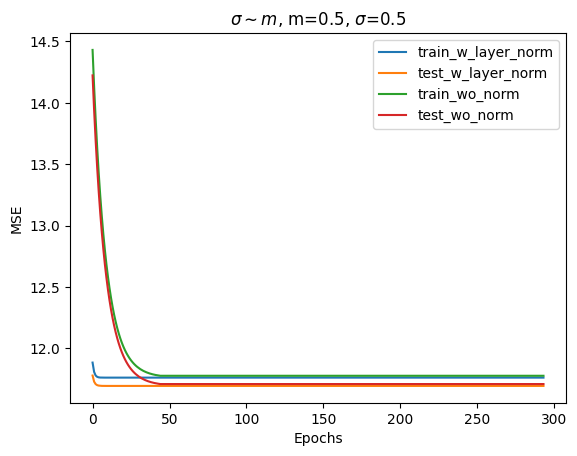

In [8]:
m = 0.5
sigma = 0.5
tr, tst, tr_n, tst_n = compare(m, sigma, 0.8)

plt.title(f'$\sigma \sim |m|$, m={m}, $\sigma$={sigma}')
plot_results(tr, tst, tr_n, tst_n, skip_first=6)

  1%|          | 1/100 [00:00<00:59,  1.67it/s]

LOSS: train 942.83513828125, validation 911.3437255859375


 11%|█         | 11/100 [00:06<00:54,  1.65it/s]

LOSS: train 854.2011791015625, validation 848.8103912353515


 21%|██        | 21/100 [00:12<00:46,  1.69it/s]

LOSS: train 832.721675390625, validation 828.2529205322265


 31%|███       | 31/100 [00:18<00:39,  1.73it/s]

LOSS: train 825.703611328125, validation 821.4518493652344


 41%|████      | 41/100 [00:24<00:35,  1.66it/s]

LOSS: train 823.4096168945313, validation 819.1806549072265


 51%|█████     | 51/100 [00:30<00:29,  1.68it/s]

LOSS: train 822.6592122070313, validation 818.4102264404297


 61%|██████    | 61/100 [00:36<00:23,  1.68it/s]

LOSS: train 822.4134283203125, validation 818.142221069336


 71%|███████   | 71/100 [00:42<00:17,  1.67it/s]

LOSS: train 822.332737890625, validation 818.0453002929687


 81%|████████  | 81/100 [00:48<00:11,  1.61it/s]

LOSS: train 822.3061578125, validation 818.00830078125


 81%|████████  | 81/100 [00:49<00:11,  1.64it/s]


Switching models


  1%|          | 1/100 [00:00<00:59,  1.65it/s]

LOSS: train 1427.235408203125, validation 1184.7100646972656


 11%|█         | 11/100 [00:06<00:56,  1.56it/s]

LOSS: train 822.2471881835937, validation 818.0319305419922


 18%|█▊        | 18/100 [00:12<00:54,  1.50it/s]

Final loss on train:
With layer_norm 822.2035581054688, without 822.3047831054688
--------------------------------------------------
Final loss on test:
With layer_norm 817.9365997314453, without 818.0061218261719


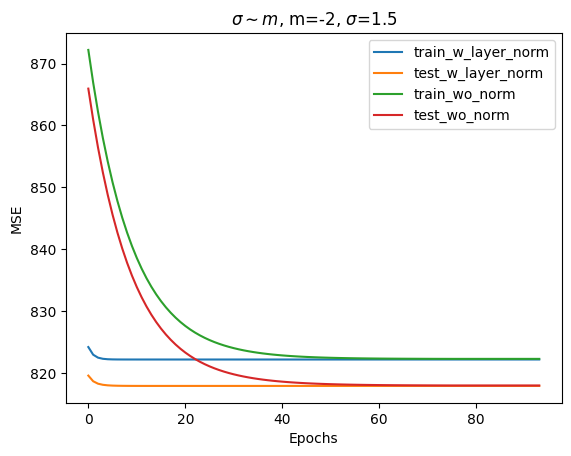

In [9]:
m = -2
sigma = 1.5

tr, tst, tr_n, tst_n = compare(m, sigma, 0.8, n_epochs=100)

plt.title(f'$\sigma \sim |m|$, m={m}, $\sigma$={sigma}')
plot_results(tr, tst, tr_n, tst_n, skip_first=6)

### $|m| \gg \sigma$

  0%|          | 1/400 [00:00<04:47,  1.39it/s]

LOSS: train 10.01355347290039, validation 3.4513593673706056


  3%|▎         | 11/400 [00:08<04:43,  1.37it/s]

LOSS: train 3.2814024887084963, validation 3.326979410648346


  5%|▌         | 21/400 [00:14<04:25,  1.43it/s]

LOSS: train 3.2065926418304445, validation 3.2500679731369018


  8%|▊         | 31/400 [00:21<03:46,  1.63it/s]

LOSS: train 3.1358393539428713, validation 3.177505314350128


 10%|█         | 41/400 [00:27<03:48,  1.57it/s]

LOSS: train 3.0680419635772704, validation 3.1080159187316894


 13%|█▎        | 51/400 [00:34<04:03,  1.43it/s]

LOSS: train 3.0030605060577393, validation 3.04141446352005


 15%|█▌        | 61/400 [00:41<03:51,  1.47it/s]

LOSS: train 2.940777862548828, validation 2.9775745987892153


 18%|█▊        | 71/400 [00:48<03:48,  1.44it/s]

LOSS: train 2.8810822578430177, validation 2.916382896900177


 20%|██        | 81/400 [00:55<03:48,  1.40it/s]

LOSS: train 2.823865715408325, validation 2.8577274441719056


 23%|██▎       | 91/400 [01:02<03:25,  1.51it/s]

LOSS: train 2.7690252117156984, validation 2.801503372192383


 25%|██▌       | 101/400 [01:09<03:22,  1.48it/s]

LOSS: train 2.716462100982666, validation 2.7476093053817747


 28%|██▊       | 111/400 [01:16<03:05,  1.56it/s]

LOSS: train 2.6660820793151854, validation 2.6959500312805176


 30%|███       | 121/400 [01:22<03:00,  1.55it/s]

LOSS: train 2.617795045089722, validation 2.646432435512543


 33%|███▎      | 131/400 [01:28<02:51,  1.56it/s]

LOSS: train 2.5715128761291504, validation 2.5989667773246765


 35%|███▌      | 141/400 [01:35<02:52,  1.50it/s]

LOSS: train 2.5271536613464356, validation 2.5534689903259276


 38%|███▊      | 151/400 [01:42<02:44,  1.52it/s]

LOSS: train 2.4846363311767576, validation 2.509856808185577


 40%|████      | 161/400 [01:48<02:33,  1.55it/s]

LOSS: train 2.443884939575195, validation 2.4680519223213198


 43%|████▎     | 171/400 [01:54<02:17,  1.67it/s]

LOSS: train 2.404825949478149, validation 2.4279797077178955


 45%|████▌     | 181/400 [02:01<02:14,  1.63it/s]

LOSS: train 2.367388440322876, validation 2.3895673751831055


 48%|████▊     | 191/400 [02:07<02:11,  1.59it/s]

LOSS: train 2.33150712890625, validation 2.3527480363845825


 50%|█████     | 201/400 [02:13<02:05,  1.58it/s]

LOSS: train 2.297115696334839, validation 2.317453992366791


 53%|█████▎    | 211/400 [02:20<02:00,  1.56it/s]

LOSS: train 2.2641534156799317, validation 2.28362318277359


 55%|█████▌    | 221/400 [02:26<01:55,  1.55it/s]

LOSS: train 2.232558869934082, validation 2.2511929512023925


 58%|█████▊    | 231/400 [02:32<01:41,  1.67it/s]

LOSS: train 2.2022781818389894, validation 2.2201076626777647


 60%|██████    | 241/400 [02:39<01:54,  1.39it/s]

LOSS: train 2.1732544021606444, validation 2.1903099536895754


 63%|██████▎   | 251/400 [02:46<01:47,  1.38it/s]

LOSS: train 2.1454367935180665, validation 2.1617470383644104


 65%|██████▌   | 261/400 [02:53<01:40,  1.38it/s]

LOSS: train 2.1187732688903806, validation 2.1343664050102236


 68%|██████▊   | 271/400 [03:01<01:40,  1.29it/s]

LOSS: train 2.0932188159942626, validation 2.1081211090087892


 70%|███████   | 281/400 [03:09<01:36,  1.23it/s]

LOSS: train 2.0687247520446777, validation 2.0829619228839875


 73%|███████▎  | 291/400 [03:16<01:24,  1.30it/s]

LOSS: train 2.0452486358642576, validation 2.058845764398575


 75%|███████▌  | 301/400 [03:25<01:20,  1.23it/s]

LOSS: train 2.022745154953003, validation 2.0357258021831512


 78%|███████▊  | 311/400 [03:32<01:07,  1.32it/s]

LOSS: train 2.0011773937225343, validation 2.013564646244049


 80%|████████  | 321/400 [03:40<00:58,  1.35it/s]

LOSS: train 1.9805061777114867, validation 1.9923214793205262


 83%|████████▎ | 331/400 [03:47<00:50,  1.36it/s]

LOSS: train 1.9606922534942628, validation 1.9719568192958832


 85%|████████▌ | 341/400 [03:55<00:43,  1.36it/s]

LOSS: train 1.94170219745636, validation 1.9524368166923523


 88%|████████▊ | 351/400 [04:02<00:36,  1.36it/s]

LOSS: train 1.9235016792297364, validation 1.933725357055664


 90%|█████████ | 361/400 [04:10<00:29,  1.33it/s]

LOSS: train 1.906055622291565, validation 1.9157869458198546


 93%|█████████▎| 371/400 [04:17<00:21,  1.33it/s]

LOSS: train 1.889333984375, validation 1.898591196537018


 95%|█████████▌| 381/400 [04:25<00:14,  1.33it/s]

LOSS: train 1.8733080261230468, validation 1.8821082174777986


 98%|█████████▊| 391/400 [04:32<00:06,  1.32it/s]

LOSS: train 1.857947488975525, validation 1.8663073539733888


100%|██████████| 400/400 [04:39<00:00,  1.43it/s]


Switching models


  0%|          | 1/400 [00:00<04:07,  1.61it/s]

LOSS: train 271.14923586425783, validation 161.4889129638672


  3%|▎         | 11/400 [00:07<04:24,  1.47it/s]

LOSS: train 1.5230562917709352, validation 1.5067736566066743


  5%|▌         | 21/400 [00:14<04:17,  1.47it/s]

LOSS: train 1.5031666120529175, validation 1.4934549152851104


  8%|▊         | 31/400 [00:20<04:09,  1.48it/s]

LOSS: train 1.5031664979934691, validation 1.4934415161609649


 10%|█         | 41/400 [00:27<03:56,  1.51it/s]

LOSS: train 1.503166478729248, validation 1.4934414446353912


 13%|█▎        | 51/400 [00:34<03:53,  1.49it/s]

LOSS: train 1.503166480255127, validation 1.4934414386749268


 15%|█▌        | 61/400 [00:41<03:51,  1.47it/s]

LOSS: train 1.503166480255127, validation 1.4934414386749268


 18%|█▊        | 71/400 [00:48<03:53,  1.41it/s]

LOSS: train 1.503166480255127, validation 1.4934414386749268


 20%|██        | 81/400 [00:54<03:38,  1.46it/s]

LOSS: train 1.503166480255127, validation 1.4934414386749268


 23%|██▎       | 91/400 [01:01<03:29,  1.47it/s]

LOSS: train 1.503166480255127, validation 1.4934414386749268


 25%|██▌       | 101/400 [01:08<03:17,  1.52it/s]

LOSS: train 1.503166480255127, validation 1.4934414386749268


 28%|██▊       | 111/400 [01:15<03:17,  1.46it/s]

LOSS: train 1.503166480255127, validation 1.4934414386749268


 30%|███       | 121/400 [01:22<03:21,  1.38it/s]

LOSS: train 1.503166480255127, validation 1.4934414386749268


 33%|███▎      | 131/400 [01:29<03:03,  1.46it/s]

LOSS: train 1.503166480255127, validation 1.4934414386749268


 35%|███▌      | 141/400 [01:36<02:55,  1.48it/s]

LOSS: train 1.503166480255127, validation 1.4934414386749268


 38%|███▊      | 151/400 [01:42<02:48,  1.48it/s]

LOSS: train 1.503166480255127, validation 1.4934414386749268


 40%|████      | 161/400 [01:49<02:43,  1.46it/s]

LOSS: train 1.503166480255127, validation 1.4934414386749268


 43%|████▎     | 171/400 [01:56<02:33,  1.50it/s]

LOSS: train 1.503166480255127, validation 1.4934414386749268


 45%|████▌     | 181/400 [02:02<02:27,  1.48it/s]

LOSS: train 1.503166480255127, validation 1.4934414386749268


 48%|████▊     | 191/400 [02:09<02:18,  1.51it/s]

LOSS: train 1.503166480255127, validation 1.4934414386749268


 50%|█████     | 201/400 [02:16<02:10,  1.52it/s]

LOSS: train 1.503166480255127, validation 1.4934414386749268


 53%|█████▎    | 211/400 [02:22<02:04,  1.52it/s]

LOSS: train 1.503166480255127, validation 1.4934414386749268


 55%|█████▌    | 221/400 [02:29<01:57,  1.52it/s]

LOSS: train 1.503166480255127, validation 1.4934414386749268


 58%|█████▊    | 231/400 [02:36<01:54,  1.48it/s]

LOSS: train 1.503166480255127, validation 1.4934414386749268


 60%|██████    | 241/400 [02:43<01:49,  1.45it/s]

LOSS: train 1.503166480255127, validation 1.4934414386749268


 63%|██████▎   | 251/400 [02:49<01:40,  1.49it/s]

LOSS: train 1.503166480255127, validation 1.4934414386749268


 65%|██████▌   | 261/400 [02:56<01:35,  1.46it/s]

LOSS: train 1.503166480255127, validation 1.4934414386749268


 68%|██████▊   | 271/400 [03:03<01:30,  1.42it/s]

LOSS: train 1.503166480255127, validation 1.4934414386749268


 70%|███████   | 281/400 [03:10<01:22,  1.45it/s]

LOSS: train 1.503166480255127, validation 1.4934414386749268


 73%|███████▎  | 291/400 [03:17<01:15,  1.45it/s]

LOSS: train 1.503166480255127, validation 1.4934414386749268


 75%|███████▌  | 301/400 [03:24<01:07,  1.46it/s]

LOSS: train 1.503166480255127, validation 1.4934414386749268


 78%|███████▊  | 311/400 [03:31<00:59,  1.50it/s]

LOSS: train 1.503166480255127, validation 1.4934414386749268


 80%|████████  | 321/400 [03:37<00:52,  1.49it/s]

LOSS: train 1.503166480255127, validation 1.4934414386749268


 83%|████████▎ | 331/400 [03:44<00:46,  1.49it/s]

LOSS: train 1.503166480255127, validation 1.4934414386749268


 85%|████████▌ | 341/400 [03:51<00:40,  1.45it/s]

LOSS: train 1.503166480255127, validation 1.4934414386749268


 88%|████████▊ | 351/400 [03:58<00:33,  1.48it/s]

LOSS: train 1.503166480255127, validation 1.4934414386749268


 90%|█████████ | 361/400 [04:04<00:26,  1.48it/s]

LOSS: train 1.503166480255127, validation 1.4934414386749268


 93%|█████████▎| 371/400 [04:11<00:19,  1.47it/s]

LOSS: train 1.503166480255127, validation 1.4934414386749268


 95%|█████████▌| 381/400 [04:18<00:12,  1.48it/s]

LOSS: train 1.503166480255127, validation 1.4934414386749268


 98%|█████████▊| 391/400 [04:25<00:06,  1.48it/s]

LOSS: train 1.503166480255127, validation 1.4934414386749268


100%|██████████| 400/400 [04:31<00:00,  1.48it/s]

Final loss on train:
With layer_norm 1.503166480255127, without 1.8446694471359253
--------------------------------------------------
Final loss on test:
With layer_norm 1.4934414386749268, without 1.8526470422744752


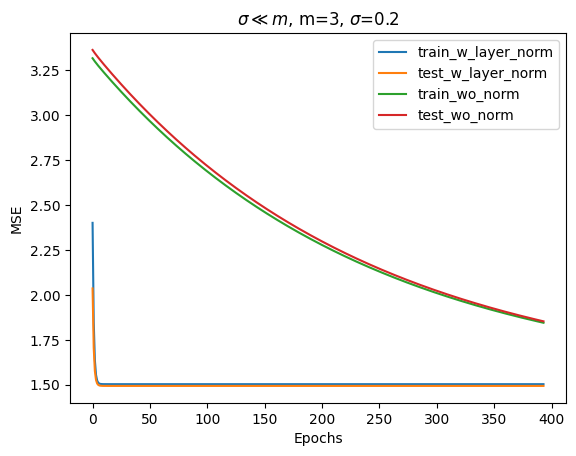

In [18]:
m = 3
sigma = 0.2

tr, tst, tr_n, tst_n = compare(m, sigma, 0.8, n_epochs=400)

plt.title(f'$\sigma \ll |m|$, m={m}, $\sigma$={sigma}')
plot_results(tr, tst, tr_n, tst_n, skip_first=6)

  0%|          | 1/400 [00:00<05:48,  1.15it/s]

LOSS: train 25.398779501342773, validation 8.464858198165894


  3%|▎         | 11/400 [00:09<05:50,  1.11it/s]

LOSS: train 7.990219778442383, validation 7.867707681655884


  5%|▌         | 21/400 [00:17<04:09,  1.52it/s]

LOSS: train 7.518348306274414, validation 7.40530641078949


  8%|▊         | 31/400 [00:23<03:50,  1.60it/s]

LOSS: train 7.09162140045166, validation 6.987036967277527


 10%|█         | 41/400 [00:29<03:45,  1.60it/s]

LOSS: train 6.7039667442321775, validation 6.6071022033691404


 13%|█▎        | 51/400 [00:36<03:59,  1.46it/s]

LOSS: train 6.351757068634033, validation 6.2619280338287355


 15%|█▌        | 61/400 [00:43<03:45,  1.51it/s]

LOSS: train 6.03174681854248, validation 5.948328065872192


 18%|█▊        | 71/400 [00:49<03:29,  1.57it/s]

LOSS: train 5.740992320251465, validation 5.66341495513916


 20%|██        | 81/400 [00:55<03:15,  1.63it/s]

LOSS: train 5.476817321014404, validation 5.404564285278321


 23%|██▎       | 91/400 [01:01<03:04,  1.67it/s]

LOSS: train 5.236797827148438, validation 5.169395852088928


 25%|██▌       | 101/400 [01:10<04:34,  1.09it/s]

LOSS: train 5.018715673828125, validation 4.9557377099990845


 28%|██▊       | 111/400 [01:18<04:07,  1.17it/s]

LOSS: train 4.820569652557373, validation 4.7616252422332765


 30%|███       | 121/400 [01:26<03:49,  1.21it/s]

LOSS: train 4.640540991210938, validation 4.585273694992066


 33%|███▎      | 131/400 [01:35<03:57,  1.13it/s]

LOSS: train 4.476970899200439, validation 4.4250588655471805


 35%|███▌      | 141/400 [01:43<03:36,  1.20it/s]

LOSS: train 4.328356489562989, validation 4.279503560066223


 38%|███▊      | 151/400 [01:52<03:25,  1.21it/s]

LOSS: train 4.193327334594726, validation 4.147266817092896


 40%|████      | 161/400 [02:00<03:18,  1.20it/s]

LOSS: train 4.070640921020508, validation 4.0271278619766235


 43%|████▎     | 171/400 [02:08<03:14,  1.17it/s]

LOSS: train 3.9591695556640625, validation 3.917981815338135


 45%|████▌     | 181/400 [02:17<03:05,  1.18it/s]

LOSS: train 3.857891059875488, validation 3.8188255190849305


 48%|████▊     | 191/400 [02:25<02:51,  1.22it/s]

LOSS: train 3.7658731163024903, validation 3.7287463665008547


 50%|█████     | 201/400 [02:34<02:56,  1.13it/s]

LOSS: train 3.682265732192993, validation 3.646908700466156


 53%|█████▎    | 211/400 [02:42<02:41,  1.17it/s]

LOSS: train 3.6063025032043456, validation 3.5725624561309814


 55%|█████▌    | 221/400 [02:51<02:33,  1.17it/s]

LOSS: train 3.537284052276611, validation 3.5050214767456054


 58%|█████▊    | 231/400 [02:59<02:24,  1.17it/s]

LOSS: train 3.4745802642822268, validation 3.4436684608459474


 60%|██████    | 241/400 [03:08<02:21,  1.12it/s]

LOSS: train 3.4176034061431886, validation 3.3879252910614013


 63%|██████▎   | 251/400 [03:17<02:08,  1.16it/s]

LOSS: train 3.36583761138916, validation 3.3372882485389708


 65%|██████▌   | 261/400 [03:25<02:00,  1.16it/s]

LOSS: train 3.3188027858734133, validation 3.2912870049476624


 68%|██████▊   | 271/400 [03:34<01:47,  1.20it/s]

LOSS: train 3.2760696254730224, validation 3.249497640132904


 70%|███████   | 281/400 [03:43<01:48,  1.09it/s]

LOSS: train 3.2372398525238038, validation 3.211531949043274


 73%|███████▎  | 291/400 [03:52<01:36,  1.12it/s]

LOSS: train 3.201960050201416, validation 3.177043652534485


 75%|███████▌  | 301/400 [04:00<01:20,  1.23it/s]

LOSS: train 3.169907294464111, validation 3.1457149505615236


 78%|███████▊  | 311/400 [04:08<01:14,  1.19it/s]

LOSS: train 3.140783833694458, validation 3.1172565102577208


 80%|████████  | 321/400 [04:16<01:05,  1.20it/s]

LOSS: train 3.1143213851928713, validation 3.0914016127586366


 83%|████████▎ | 331/400 [04:25<00:59,  1.16it/s]

LOSS: train 3.090278700637817, validation 3.0679166197776793


 85%|████████▌ | 341/400 [04:33<00:49,  1.18it/s]

LOSS: train 3.0684359970092774, validation 3.0465849161148073


 88%|████████▊ | 351/400 [04:42<00:43,  1.13it/s]

LOSS: train 3.048589082336426, validation 3.027207040786743


 90%|█████████ | 361/400 [04:51<00:34,  1.14it/s]

LOSS: train 3.0305563102722166, validation 3.009604573249817


 93%|█████████▎| 371/400 [05:00<00:25,  1.15it/s]

LOSS: train 3.014171499633789, validation 2.993615007400513


 95%|█████████▌| 381/400 [05:08<00:16,  1.15it/s]

LOSS: train 2.9992860786437987, validation 2.979092228412628


 98%|█████████▊| 391/400 [05:16<00:07,  1.23it/s]

LOSS: train 2.9857613876342772, validation 2.9659008026123046


100%|██████████| 400/400 [05:24<00:00,  1.23it/s]


Switching models


  0%|          | 1/400 [00:00<05:58,  1.11it/s]

LOSS: train 382.5107973388672, validation 226.9372528076172


  3%|▎         | 11/400 [00:09<05:39,  1.14it/s]

LOSS: train 2.8783981575012207, validation 2.8429181575775146


  5%|▌         | 20/400 [00:18<05:50,  1.08it/s]

LOSS: train 2.850953705215454, validation 2.8334480047225954
Final loss on train:
With layer_norm 2.850953705215454, without 2.9746505195617674
--------------------------------------------------
Final loss on test:
With layer_norm 2.8334480047225954, without 2.955066680908203


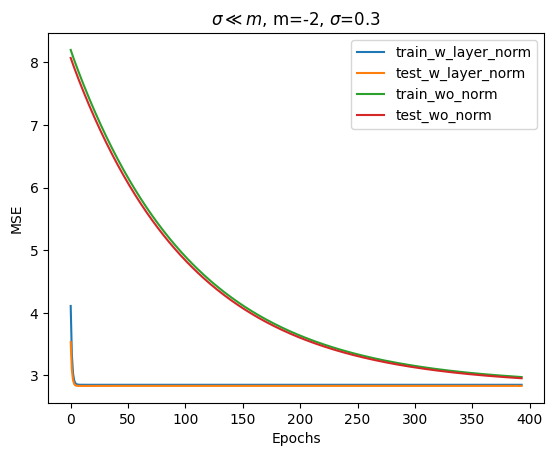

In [13]:
m = -2
sigma = 0.3

tr, tst, tr_n, tst_n = compare(m, sigma, 0.8, n_epochs=400)

plt.title(f'$\sigma \ll |m|$, m={m}, $\sigma$={sigma}')
plot_results(tr, tst, tr_n, tst_n, skip_first=6)

### $|m| \ll \sigma$

  1%|          | 1/100 [00:01<01:40,  1.02s/it]

LOSS: train 372.2796037109375, validation 368.18798370361327


 11%|█         | 11/100 [00:09<01:18,  1.13it/s]

LOSS: train 371.8759567871094, validation 367.8259643554687


 21%|██        | 21/100 [00:18<01:06,  1.19it/s]

LOSS: train 371.8241751953125, validation 367.7794662475586


 31%|███       | 31/100 [00:27<01:00,  1.14it/s]

LOSS: train 371.81631020507814, validation 367.7728210449219


 41%|████      | 41/100 [00:35<00:51,  1.14it/s]

LOSS: train 371.81491708984373, validation 367.7719360351563


 51%|█████     | 51/100 [00:44<00:43,  1.13it/s]

LOSS: train 371.8146724609375, validation 367.7719451904297


 61%|██████    | 61/100 [00:53<00:34,  1.12it/s]

LOSS: train 371.81464233398435, validation 367.7720611572266


 71%|███████   | 71/100 [01:02<00:25,  1.15it/s]

LOSS: train 371.81465400390624, validation 367.7721420288086


 81%|████████  | 81/100 [01:10<00:16,  1.18it/s]

LOSS: train 371.81466005859374, validation 367.7721893310547


 91%|█████████ | 91/100 [01:19<00:07,  1.22it/s]

LOSS: train 371.81467333984375, validation 367.77220458984374


100%|██████████| 100/100 [01:26<00:00,  1.16it/s]


Switching models


  1%|          | 1/100 [00:00<01:21,  1.21it/s]

LOSS: train 372.1231139160156, validation 368.03941650390624


 11%|█         | 11/100 [00:09<01:14,  1.19it/s]

LOSS: train 371.86822905273436, validation 367.8152114868164


 21%|██        | 21/100 [00:17<01:06,  1.18it/s]

LOSS: train 371.823855078125, validation 367.7781295776367


 31%|███       | 31/100 [00:25<00:52,  1.30it/s]

LOSS: train 371.81618671875, validation 367.77257385253904


 41%|████      | 41/100 [00:32<00:38,  1.55it/s]

LOSS: train 371.81488994140625, validation 367.77200469970705


 51%|█████     | 51/100 [00:39<00:32,  1.49it/s]

LOSS: train 371.81468598632813, validation 367.7720687866211


 61%|██████    | 61/100 [00:45<00:25,  1.54it/s]

LOSS: train 371.8146626953125, validation 367.7721694946289


 71%|███████   | 71/100 [00:52<00:20,  1.42it/s]

LOSS: train 371.8146678222656, validation 367.7722137451172


 81%|████████  | 81/100 [00:59<00:12,  1.47it/s]

LOSS: train 371.81466533203127, validation 367.7722427368164


 91%|█████████ | 91/100 [01:05<00:06,  1.49it/s]

LOSS: train 371.8146681640625, validation 367.7722473144531


100%|██████████| 100/100 [01:12<00:00,  1.39it/s]

Final loss on train:
With layer_norm 371.81466772460936, without 371.81467470703126
--------------------------------------------------
Final loss on test:
With layer_norm 367.77225189208986, without 367.77221832275393


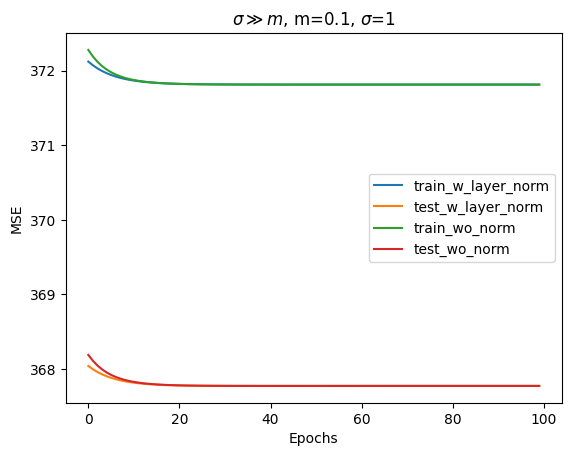

In [21]:
m = 0.1
sigma = 1

tr, tst, tr_n, tst_n = compare(m, sigma, 0.8, n_epochs=100, lr=5e-4)

plt.title(f'$\sigma \gg |m|$, m={m}, $\sigma$={sigma}')
plot_results(tr, tst, tr_n, tst_n, skip_first=0)

  0%|          | 1/300 [00:00<03:54,  1.27it/s]

LOSS: train 5394.01019921875, validation 5390.133520507812


  4%|▎         | 11/300 [00:07<03:24,  1.42it/s]

LOSS: train 5389.2611046875, validation 5387.880395507813


  7%|▋         | 21/300 [00:14<03:15,  1.43it/s]

LOSS: train 5388.6523640625, validation 5387.678540039063


 10%|█         | 31/300 [00:21<03:07,  1.44it/s]

LOSS: train 5388.52088671875, validation 5387.72421875


 14%|█▎        | 41/300 [00:29<03:08,  1.37it/s]

LOSS: train 5388.4923296875, validation 5387.775122070312


 17%|█▋        | 51/300 [00:36<03:21,  1.24it/s]

LOSS: train 5388.48599375, validation 5387.804956054688


 20%|██        | 61/300 [00:45<03:12,  1.24it/s]

LOSS: train 5388.484525, validation 5387.820263671875


 24%|██▎       | 71/300 [00:53<03:04,  1.24it/s]

LOSS: train 5388.4841671875, validation 5387.8275390625


 27%|██▋       | 81/300 [01:01<02:56,  1.24it/s]

LOSS: train 5388.48407578125, validation 5387.8310546875


 30%|███       | 91/300 [01:09<02:46,  1.26it/s]

LOSS: train 5388.48402421875, validation 5387.832666015625


 34%|███▎      | 101/300 [01:16<02:30,  1.32it/s]

LOSS: train 5388.484025, validation 5387.833422851562


 37%|███▋      | 111/300 [01:24<02:26,  1.29it/s]

LOSS: train 5388.4840328125, validation 5387.833764648438


 40%|████      | 121/300 [01:32<02:21,  1.27it/s]

LOSS: train 5388.4840078125, validation 5387.833837890625


 44%|████▎     | 131/300 [01:40<02:13,  1.27it/s]

LOSS: train 5388.4840015625, validation 5387.8338623046875


 47%|████▋     | 141/300 [01:48<02:06,  1.25it/s]

LOSS: train 5388.4839953125, validation 5387.834008789063


 50%|█████     | 151/300 [01:55<01:54,  1.30it/s]

LOSS: train 5388.4839765625, validation 5387.833984375


 54%|█████▎    | 161/300 [02:03<01:44,  1.33it/s]

LOSS: train 5388.4840140625, validation 5387.833959960937


 57%|█████▋    | 171/300 [02:11<01:35,  1.35it/s]

LOSS: train 5388.4840515625, validation 5387.833935546875


 60%|██████    | 181/300 [02:18<01:29,  1.34it/s]

LOSS: train 5388.4840203125, validation 5387.833984375


 64%|██████▎   | 191/300 [02:25<01:18,  1.39it/s]

LOSS: train 5388.4840203125, validation 5387.833984375


 67%|██████▋   | 201/300 [02:33<01:15,  1.32it/s]

LOSS: train 5388.4840203125, validation 5387.833984375


 70%|███████   | 211/300 [02:41<01:09,  1.28it/s]

LOSS: train 5388.4840203125, validation 5387.833984375


 74%|███████▎  | 221/300 [02:48<01:01,  1.28it/s]

LOSS: train 5388.4840203125, validation 5387.833984375


 77%|███████▋  | 231/300 [02:56<00:55,  1.23it/s]

LOSS: train 5388.4840203125, validation 5387.833984375


 80%|████████  | 241/300 [03:04<00:46,  1.27it/s]

LOSS: train 5388.4840203125, validation 5387.833984375


 84%|████████▎ | 251/300 [03:12<00:38,  1.26it/s]

LOSS: train 5388.4840203125, validation 5387.833984375


 87%|████████▋ | 261/300 [03:20<00:30,  1.26it/s]

LOSS: train 5388.4840203125, validation 5387.833984375


 90%|█████████ | 271/300 [03:28<00:22,  1.28it/s]

LOSS: train 5388.4840203125, validation 5387.833984375


 94%|█████████▎| 281/300 [03:36<00:14,  1.29it/s]

LOSS: train 5388.4840203125, validation 5387.833984375


 97%|█████████▋| 291/300 [03:44<00:07,  1.26it/s]

LOSS: train 5388.4840203125, validation 5387.833984375


100%|██████████| 300/300 [03:51<00:00,  1.30it/s]


Switching models


  0%|          | 1/300 [00:00<04:13,  1.18it/s]

LOSS: train 5394.03440859375, validation 5391.227856445313


  4%|▎         | 11/300 [00:09<03:58,  1.21it/s]

LOSS: train 5389.6136125, validation 5388.09140625


  7%|▋         | 21/300 [00:16<03:40,  1.27it/s]

LOSS: train 5388.714115625, validation 5387.69208984375


 10%|█         | 31/300 [00:24<03:36,  1.24it/s]

LOSS: train 5388.529978125, validation 5387.71796875


 14%|█▎        | 41/300 [00:33<03:28,  1.24it/s]

LOSS: train 5388.4919078125, validation 5387.771801757813


 17%|█▋        | 51/300 [00:40<03:05,  1.34it/s]

LOSS: train 5388.48395625, validation 5387.804516601563


 20%|██        | 61/300 [00:48<03:13,  1.24it/s]

LOSS: train 5388.482178125, validation 5387.821337890625


 24%|██▎       | 71/300 [00:56<02:56,  1.30it/s]

LOSS: train 5388.4818359375, validation 5387.829296875


 27%|██▋       | 81/300 [01:04<02:49,  1.29it/s]

LOSS: train 5388.48168203125, validation 5387.832934570312


 30%|███       | 91/300 [01:11<02:38,  1.32it/s]

LOSS: train 5388.4816546875, validation 5387.834643554687


 34%|███▎      | 101/300 [01:19<02:29,  1.33it/s]

LOSS: train 5388.48165625, validation 5387.8353271484375


 37%|███▋      | 111/300 [01:27<02:33,  1.23it/s]

LOSS: train 5388.4816765625, validation 5387.83564453125


 40%|████      | 121/300 [01:35<02:21,  1.26it/s]

LOSS: train 5388.4816265625, validation 5387.8359375


 44%|████▎     | 131/300 [01:43<02:08,  1.31it/s]

LOSS: train 5388.4816390625, validation 5387.836010742188


 47%|████▋     | 141/300 [01:51<02:05,  1.27it/s]

LOSS: train 5388.48163203125, validation 5387.8361328125


 50%|█████     | 151/300 [01:59<01:57,  1.27it/s]

LOSS: train 5388.4816578125, validation 5387.836108398437


 54%|█████▎    | 161/300 [02:06<01:50,  1.25it/s]

LOSS: train 5388.48161953125, validation 5387.8361328125


 57%|█████▋    | 171/300 [02:15<01:46,  1.21it/s]

LOSS: train 5388.4816203125, validation 5387.8361328125


 60%|██████    | 181/300 [02:23<01:31,  1.31it/s]

LOSS: train 5388.4816203125, validation 5387.836157226562


 64%|██████▎   | 191/300 [02:30<01:27,  1.25it/s]

LOSS: train 5388.4816140625, validation 5387.836157226562


 67%|██████▋   | 201/300 [02:38<01:18,  1.26it/s]

LOSS: train 5388.4816140625, validation 5387.836157226562


 70%|███████   | 211/300 [02:46<01:10,  1.27it/s]

LOSS: train 5388.4816015625, validation 5387.836157226562


 74%|███████▎  | 221/300 [02:54<01:05,  1.21it/s]

LOSS: train 5388.4816015625, validation 5387.836157226562


 77%|███████▋  | 231/300 [03:02<00:54,  1.28it/s]

LOSS: train 5388.4816015625, validation 5387.8361328125


 80%|████████  | 241/300 [03:10<00:47,  1.23it/s]

LOSS: train 5388.4816015625, validation 5387.836157226562


 84%|████████▎ | 251/300 [03:18<00:39,  1.23it/s]

LOSS: train 5388.4816015625, validation 5387.836157226562


 87%|████████▋ | 261/300 [03:26<00:29,  1.31it/s]

LOSS: train 5388.4816015625, validation 5387.836157226562


 90%|█████████ | 271/300 [03:34<00:23,  1.25it/s]

LOSS: train 5388.4816015625, validation 5387.836157226562


 94%|█████████▎| 281/300 [03:42<00:14,  1.27it/s]

LOSS: train 5388.4816015625, validation 5387.836157226562


 97%|█████████▋| 291/300 [03:50<00:07,  1.28it/s]

LOSS: train 5388.4816015625, validation 5387.836157226562


100%|██████████| 300/300 [03:57<00:00,  1.26it/s]

Final loss on train:
With layer_norm 5388.4816015625, without 5388.4840203125
--------------------------------------------------
Final loss on test:
With layer_norm 5387.836157226562, without 5387.833984375


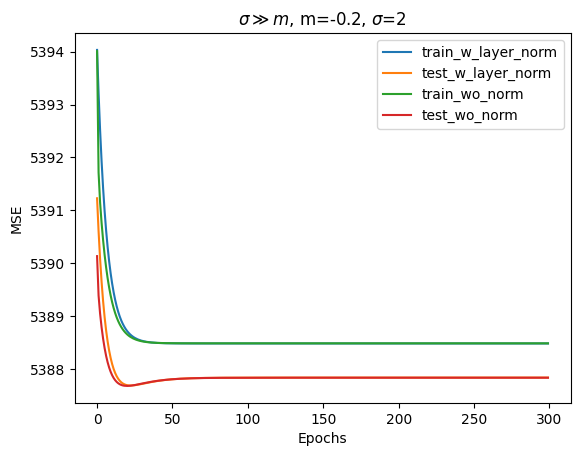

In [22]:
m = -0.2
sigma = 2

tr, tst, tr_n, tst_n = compare(m, sigma, 0.8, lr=5e-4)

plt.title(f'$\sigma \gg |m|$, m={m}, $\sigma$={sigma}')
plot_results(tr, tst, tr_n, tst_n, skip_first=0)

Analyzing the results, we can say that in our case layer norm always speeds the convergence in all the regimes. The biggest gap in speed of convergence is achieved when $m \gg \sigma$, as $\frac{\sigma}{|m|}$ increases the difference becomes less noticeable. Perfomance of the model with layer norm is also always better than the one without norm but the difference is smaller than 0.1% when both models fully converge.

### Theoretical approach
Here we will try to explain why model with Layer Norm convergences faster: <br>
Basically we are solving a quadratic optimization problem:
$$\min_{w} \|y - Xw\|^2_2, \quad y \in \mathbb{R}^n, \; w \in \mathbb{R}^p $$
Where $X = \begin{pmatrix} x^1_1 & \ldots & x^1_p \\ & \ldots & \\ x^n_1 & \ldots & x^n_p \end{pmatrix} $, $\;$ $x^i$ is a single observation consisting of $(x^i_1, \ldots, x^i_p)$ corresponding to $y_i$. <br>
Let's take a look at the gradients and at the Hessian matrix:
$$ \frac{\partial}{\partial w} \|y - Xw\|^2_2 = 2 X^T(Xw - y) $$
$$ \frac{\partial}{\partial w^2} \|y - Xw\|^2_2 = \frac{\partial}{\partial w} 2 X^T(Xw - y) = 2 X^T X$$
We know that gradient descent convergence for quadratic problems depends on the ratio between the smallest ($\lambda_\text{min}$) and the largest ($\lambda_\text{max}$) eigenvalues of the Hessian ($2X^TX$ in our case) $\rightarrow$ the bigger the $\frac{\lambda_\text{min}}{\lambda_\text{max}}$ the faster the convergence. (In Russian it's called ["Соотношение Канторовича"](https://ru.wikipedia.org/wiki/Градиентный_спуск) and for English you can refer to CSC421/2516 Lectures 7–8: Optimization [page 22](https://www.cs.toronto.edu/~rgrosse/courses/csc421_2019/slides/lec07.pdf) or [wiki](https://calculus.subwiki.org/wiki/Gradient_descent_with_constant_learning_rate_for_a_quadratic_function_of_multiple_variables)). <br>
In our case $X$ consists of random vectors, so we can expect that $X^TX$ is non-singular because singualr matrices have Lebesgue measure $0$ and therefore probability of generating a singular matrix is $0$. <br> 
Now let's look at what Layer Norm does to our matrix. (Alternatively, probability of matrix $X$ having a full column rank is also 1) <br>
We will denote $\tilde{x}^i$ as the result of applying Layer Norm to vector $x^i$:
$$ \tilde{x}^i \rightarrow \frac{x^i - \mu_i}{\sigma_i}, \quad \mu_i = \frac{1}{p} \sum_{k=1}^p x^i_k, \quad \sigma_i^2 = \frac{1}{p} \sum_{k=1}^p (x^i_k - \mu_i)^2$$
$$ \tilde{X} = \begin{pmatrix} \tilde{x}^1_1 & \ldots & \tilde{x}^1_p \\ & \ldots & \\ \tilde{x}^n_1 & \ldots & \tilde{x}^n_p \end{pmatrix} $$
Now, **very important observation**:
$$ \sum_{k=1}^p \tilde{x}^i_k = \sum_{k=1}^p \frac{x^i}{\sigma_i} - \frac{p\mu_i}{\sigma_i} = 0$$
It means that columns of $\tilde{X}$ are linearly dependent and $\text{rank} (\tilde{X}) \leq p - 1$. <br>
From this observation it immediately follows that $\text{rank} (\tilde{X^T} \tilde{X}) \leq p - 1$ and $\tilde{X^T} \tilde{X}$ is singular! (Alternatively, $\exists v: \tilde{X}v = 0 \Rightarrow \tilde{X}^T \tilde{X}v = 0$)<br>
Remark 1: It is worh noting that we are assuming $n \gg m$ meaning that we have a lot more data than the dimension of our observation. It coincides with our experiments above. <br>
Denote eigenvalues of $\tilde{X}^T \tilde{X}$ as $\tilde{\lambda}$. <br>
As was said above, $X^TX$ is non-singular with probability $1$ meaning for $X^TX \rightarrow \lambda_\text{min} / \lambda_\text{max} \neq 0$. <br>
We arrive at an interesting conclusion, our next step can be to check the second smallest eigenvalue ($\tilde{\lambda}_\text{min2}$) of $\tilde{X}^T \tilde{X}$. <br> However, we can notice that in general case we can't say anything about relation between $\lambda_\text{min} / \lambda_\text{max}$ and $\tilde{\lambda}_\text{min2} / \tilde{\lambda}_\text{max}$. <br>
Consider the following matrix $X$:
$$ X = \begin{pmatrix} 3 & -10 & 3 \\ -7 & -5 & -9 \\ -6 & -9 & 5 \end{pmatrix} $$
For our's sake we will use python to check eigenvalues of $X^TX$ and $\tilde{X}^T\tilde{X}$: 

In [158]:
X = np.array([[3, -10, 3], [-7, -5, -9], [-6, -9, 5]])
X_n = (X - X.mean(axis=-1)[:, None]) / X.std(axis=-1)[:, None] # normalized
eigen_values = np.sort(np.linalg.eig(X.T @ X)[0]) # sorted eigenvalues of X^TX
eigen_values_n = np.sort(np.linalg.eig(X_n.T @ X_n)[0]) # sorted eigenvalues of $\tilde{X}^T\tilde{X}$
l_min, l_max = eigen_values[0], eigen_values[-1]
l_min_n, l_max_n = eigen_values_n[1], eigen_values_n[-1]
print('Check that the smallest eigenvalue of normalized matrix is 0:', eigen_values_n[0])
print('Regular', l_min/l_max)
print('Normalized', l_min_n/l_max_n)


Check that the smallest eigenvalue of normalized matrix is 0: 7.771561172376096e-16
Regular 0.15545079556445127
Normalized 0.12791240049007882


As we can see, in the case above unnormalized matrix is better for convergence of gradient descent. We can consider another example where normalization actually helps:
$$ X = \begin{pmatrix} 1 & 0 & 0 \\ 0 & 2 & 0 \\ 0 & 0 & 3 \end{pmatrix} $$

In [159]:
X = np.diag([1, 2, 3])
X_n = (X - X.mean(axis=-1)[:, None]) / X.std(axis=-1)[:, None] # normalized
eigen_values = np.sort(np.linalg.eig(X.T @ X)[0]) # sorted eigenvalues of X^TX
eigen_values_n = np.sort(np.linalg.eig(X_n.T @ X_n)[0]) # sorted eigenvalues of $\tilde{X}^T\tilde{X}$
l_min, l_max = eigen_values[0], eigen_values[-1]
l_min_n, l_max_n = eigen_values_n[1], eigen_values_n[-1]
print('Regular', l_min/l_max)
print('Normalized', l_min_n/l_max_n)


Regular 0.1111111111111111
Normalized 0.9999999999999998


Working with general $X$ didn't help us. Maybe we should take into account how our matrix $X$ was generated. We will explore it in the next section "Additional Simulation".

### Additional Simulation

Here we fix $m = 10$ - dimension of $z$ and $x$. <br>
$n = 100000$ - number of samples in $X$. <br>
We then generate $X$ according to our Problem Statement. We compute eigenvalues of $X^TX$ and $\tilde{X}^T \tilde{X}$ and compare $\lambda_\text{min} / \lambda_\text{max}$ with $\tilde{\lambda}_\text{min2} / \tilde{\lambda}_\text{max}$.

In [17]:
p = 10
n = 100_000
N_iterations = 300 # how many comparisons we want

m = 1
sigma = 10 # from the previous experiments we know that normalization works worse when sigma / |m| is large

In [41]:
good, bad = 0, 0 # "good" is the number of iterations where normalization helped, bad is where it made it worse
for it in tqdm(range(N_iterations)):
    X, _, __ = generate_data(m, sigma, 0.8, n=p, size=n)
    X_n = (X - X.mean(axis=-1)[:, None]) / X.std(axis=-1)[:, None]
    eigen_values = np.sort(np.linalg.eig(X.T @ X)[0]) # sorted eigenvalues of X^TX
    eigen_values_n = np.sort(np.linalg.eig(X_n.T @ X_n)[0]) # sorted eigenvalues of $\tilde{X}^T\tilde{X}$
    l_min, l_max = eigen_values[0], eigen_values[-1]
    l_min_n, l_max_n = eigen_values_n[1], eigen_values_n[-1]


    if l_min_n / l_max_n > l_min / l_max:
        good += 1
    else:
        bad += 1

print(f'Normaliztion helped in {good} cases out of {N_iterations}')
print(f'Normaliztion did not help in {bad} cases out of {N_iterations}')

100%|██████████| 300/300 [04:15<00:00,  1.18it/s]

Normaliztion helped in 295 cases out of 300
Normaliztion did not help in 5 cases out of 300


As we can see, even when we generate data according to our problem statement we can get both cases: where normalization speeds-up the convergence and where it slows it down. 

One last experiment we should do is try to fit both our models on the "bad" $X$:

First we catch the "bad" case:

In [69]:
best_sc = 0
for it in tqdm(range(N_iterations)):
    X, y, __ = generate_data(-0.05, 4, 0.8, n=p, size=n)
    X_n = (X - X.mean(axis=-1)[:, None]) / X.std(axis=-1)[:, None]
    eigen_values = np.sort(np.linalg.eig(X.T @ X)[0]) # sorted eigenvalues of X^TX
    eigen_values_n = np.sort(np.linalg.eig(X_n.T @ X_n)[0]) # sorted eigenvalues of $\tilde{X}^T\tilde{X}$
    l_min, l_max = eigen_values[0], eigen_values[-1]
    l_min_n, l_max_n = eigen_values_n[1], eigen_values_n[-1]


    if l_min / l_max - l_min_n / l_max_n > best_sc:
        best_sc = l_min / l_max - l_min_n / l_max_n
        X_bad = X
        y_bad = y

print(best_sc)

100%|██████████| 300/300 [04:02<00:00,  1.23it/s]

0.002791874813348083


Next we fit our models: (we plot only training curves and zoom in on first 10 epochs)

  1%|          | 1/100 [00:01<01:57,  1.18s/it]

LOSS: train 86970.233865, validation 86981.85658482143


 11%|█         | 11/100 [00:12<01:42,  1.15s/it]

LOSS: train 86968.2585225, validation 86981.68327487246


 13%|█▎        | 13/100 [00:16<01:48,  1.25s/it]


Switching models


  1%|          | 1/100 [00:01<01:58,  1.20s/it]

LOSS: train 86967.16453, validation 86981.46516262754


 11%|█         | 11/100 [00:12<01:43,  1.16s/it]

LOSS: train 86966.2365675, validation 86980.95902423469


 14%|█▍        | 14/100 [00:17<01:47,  1.25s/it]


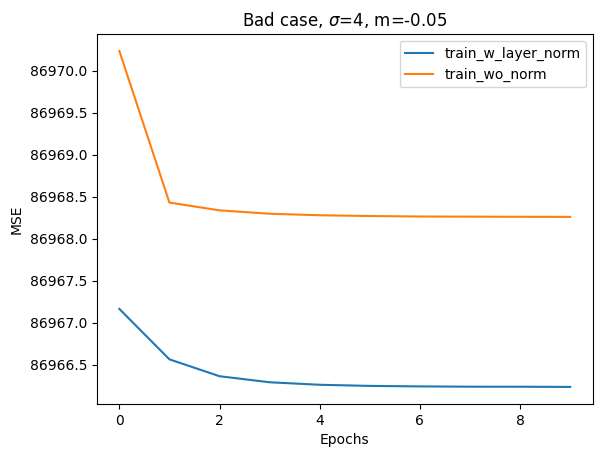

In [71]:
train_dataset = Data(X_bad, y_bad)

train_dataloader = DataLoader(train_dataset, batch_size=1024)
test_dataloader = DataLoader(train_dataset, batch_size=1024)

model_base = nn.Sequential(
nn.Linear(DIM, 1)
)

model_norm = nn.Sequential(
    nn.LayerNorm(DIM, elementwise_affine=False),
    nn.Linear(DIM, 1)
)

optimizer = SGD(model_base.parameters(), lr=3e-3)
tr, tst = train(model_base, train_dataloader, test_dataloader, nn.MSELoss(), optimizer, n_epochs=100)

print('Switching models')

optimizer_n = SGD(model_norm.parameters(), lr=3e-3)
tr_n, tst_n = train(model_norm, train_dataloader, test_dataloader, nn.MSELoss(), optimizer_n, n_epochs=100)

plt.plot(tr_n[:10], label='train_w_layer_norm')
plt.plot(tr[:10], label='train_wo_norm')
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.title(f"Bad case, $\sigma$=4, m=-0.05")
plt.legend()

### Conclusion 
We were able to study the effect of adding layer normalization for different regimes of $\sigma$ and $m$. The best effect is achived for small values of $\sigma$. We've shown that normalization makes our Hessian singular. With further experiments we've shown that normalization can both speed-up and slow down the convergence of gradient descent for the quadratic problem in general case and for our problem.